## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from utilities import df_utils

RANDOM_STATE = 5

## Data preprocessing

In [2]:
features = pd.read_csv('../data/features.csv', index_col=0)
df_utils.df_summarise(features)

(16599, 13)

Index(['customer_id', 'makes_purchase', 'last_transaction_date', 'recency',
       'recency_score', 'frequency', 'frequency_score', 'total_revenue',
       'total_revenue_score', 'rfm_score', 'rfm_segment', 'billing_zip_stem',
       'segment'],
      dtype='object')

,customer_id,makes_purchase,last_transaction_date,recency,recency_score,frequency,frequency_score,total_revenue,total_revenue_score,rfm_score,rfm_segment,billing_zip_stem,segment
0,3493717180478,0,2020-10-01 12:46:56,271,0,1,0,2445.00,2,2,low,87,3
1,3493777768510,0,2020-10-01 13:32:38,271,0,1,0,448.00,0,0,low,50,3
2,3490993078334,0,2020-10-01 13:38:06,271,0,1,0,2293.60,2,2,low,60,3
3,3433191145534,0,2020-10-01 14:28:48,271,0,1,0,438.95,0,0,low,28,3
4,3494350880830,0,2020-10-01 21:11:57,271,0,1,0,399.05,0,0,low,26,3


cat

In [3]:
# categorical_cols = [
#     'recency_score', 'frequency_score', 'total_revenue_score', 
#     'rfm_score', 'rfm_segment', 'billing_zip_stem', 'segment'
#     ]
categorical_cols = [
     'rfm_segment', 'billing_zip_stem', 'segment'
    ]
categorical_features = pd.get_dummies(
    features[categorical_cols].astype(str),
    drop_first=True
    )

num

In [5]:
# numerical_cols = ['recency', 'frequency', 'total_revenue']

numerical_cols = [
    'recency_score', 'frequency_score', 'total_revenue_score', 
    'rfm_score','recency', 'frequency', 'total_revenue'
    ]   
numerical_features = features[numerical_cols].copy()
normalised_features = preprocessing.normalize(numerical_features)
for idx, col in enumerate(numerical_cols):
    numerical_features[col] = normalised_features[:, idx]

In [6]:
model_features = pd.concat((
    numerical_features,
    categorical_features
    ), 
    axis=1)

df_utils.df_summarise(model_features)

(16599, 127)

Index(['recency_score', 'frequency_score', 'total_revenue_score', 'rfm_score',
       'recency', 'frequency', 'total_revenue', 'rfm_segment_low',
       'rfm_segment_mid', 'billing_zip_stem_10',
       ...
       'billing_zip_stem_SW40JW', 'billing_zip_stem_VALBY',
       'billing_zip_stem_nan', 'segment_10', 'segment_11', 'segment_3',
       'segment_4', 'segment_6', 'segment_7', 'segment_9'],
      dtype='object', length=127)

,recency_score,frequency_score,total_revenue_score,rfm_score,recency,frequency,total_revenue,rfm_segment_low,rfm_segment_mid,billing_zip_stem_10,...,billing_zip_stem_SW40JW,billing_zip_stem_VALBY,billing_zip_stem_nan,segment_10,segment_11,segment_3,segment_4,segment_6,segment_7,segment_9
0,0.0,0.0,0.000813,0.000813,0.110164,0.000407,0.993913,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,0.000000,0.000000,0.517581,0.001910,0.855632,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,0.000866,0.000866,0.117339,0.000433,0.993091,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,0.000000,0.000000,0.525329,0.001938,0.850897,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.000000,0.000000,0.561807,0.002073,0.827266,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Model training

In [7]:
models = {
    'knn': KNeighborsClassifier(),
    'logistic_regression': LogisticRegression(),
    'naive_bayes': GaussianNB(),
    'support_vector_machine': SVC(),
    'CART': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'xgb': xgb.XGBClassifier(use_label_encoder=False),   
}

In [8]:
train_features, val_features, train_target, val_target = train_test_split(model_features, features['makes_purchase'], test_size=0.2, random_state=RANDOM_STATE)

for model_name, model in models.items():
    kfold = KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
    result = cross_val_score(model, train_features, train_target, cv=kfold, scoring='f1')
    print(model_name, result, f'average score: {np.mean(result):.1%}')

knn [0. 0. 0.] average score: 0.0%
logistic_regression [0.         0.03846154 0.03773585] average score: 2.5%
naive_bayes [0.02042711 0.02524383 0.02121855] average score: 2.2%
support_vector_machine [0. 0. 0.] average score: 0.0%
CART [0.21621622 0.3559322  0.18018018] average score: 25.1%
random_forest [0.11111111 0.18461538 0.07142857] average score: 12.2%
[23:33:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:l

In [64]:
parameters = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2),
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=parameters,
    scoring='f1',
    n_jobs=-1,
    cv=2
    )

grid_search.fit(train_features, train_target)
grid_search.best_params_, grid_search.best_score_


/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:45:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 9, 'min_child_weight': 1}, 0.2386083743842365)

## Upsampling

In [26]:
train = pd.concat((DataFrame(train_target), train_features), axis=1)
minority_class = train[train['makes_purchase']==1].copy()
majority_class = train[train['makes_purchase']==0].copy()
n_samples = len(majority_class) - len(minority_class)
upsampled_minority_class = resample(minority_class, n_samples=n_samples, random_state=RANDOM_STATE)
len(majority_class), len(minority_class), len(upsampled_minority_class)

(13129, 150, 12979)

In [27]:
upsampled_train = pd.concat((majority_class, upsampled_minority_class))
len(upsampled_train)

26108

In [28]:
upsampled_train_target = upsampled_train['makes_purchase']
upsampled_train_features = upsampled_train.drop(columns='makes_purchase')
upsampled_train_features.shape

(26108, 127)

SMOTE

In [19]:
smote = SMOTE(random_state=RANDOM_STATE)
upsampled_train_features, upsampled_train_target = smote.fit_resample(train_features, train_target)
upsampled_train_features.shape, upsampled_train_target.shape

((26258, 127), (26258,))

In [20]:
for model_name, model in models.items():
    kfold = KFold(n_splits=4, random_state=RANDOM_STATE, shuffle=True)
    result = cross_val_score(model, upsampled_train_features, upsampled_train_target, cv=kfold, scoring='f1')
    print(model_name, result, f'average score: {np.mean(result):.1%}')

knn [0.96104668 0.95543462 0.95856597 0.96097776] average score: 95.9%


/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

logistic_regression [0.94770158 0.94439435 0.94667466 0.94868322] average score: 94.7%
naive_bayes [0.81039221 0.82355909 0.82425308 0.82074522] average score: 82.0%
support_vector_machine [0.96921911 0.97152328 0.96676737 0.97034796] average score: 96.9%
CART [0.97855513 0.97528632 0.97570545 0.97616893] average score: 97.6%
random_forest [0.98296319 0.98278466 0.98281062 0.98402652] average score: 98.3%
[23:38:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

## Evaluation

In [29]:
xgb_model = xgb.XGBClassifier().fit(upsampled_train_features, upsampled_train_target)
xgb_model.score(val_features, val_target)

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:40:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.983132530120482

In [30]:
val_predictions = xgb_model.predict(val_features)
f1_score(val_target, val_predictions)

0.3333333333333333

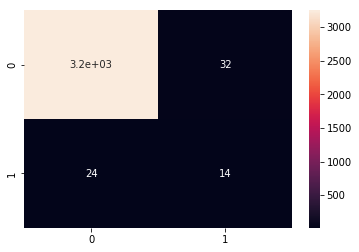

In [31]:
sns.heatmap(confusion_matrix(val_target, val_predictions), annot=True);

**Feature importance**

In [16]:
def show_feature_importance(
        feature_importances: ndarray, 
        model_features: DataFrame, 
        top_features: int = 10
        ) -> None:
    """
    Displays feature importance results
    """
    mapped_feature_importances = [
        (feature_name, feature_importance ) 
        for feature_name, feature_importance in zip(model_features.columns, feature_importances)
        ]
    sorted_feature_importances = sorted(mapped_feature_importances, key=lambda x: x[1], reverse=True)[:top_features]

    for feature_name, feature_score in sorted_feature_importances:
        print(f'{feature_name}: {feature_score:.2f}')

    top_feature_names = [feature[0] for feature in sorted_feature_importances]
    top_feature_scores = [feature[1] for feature in sorted_feature_importances]

    plt.figure(figsize=(20,10))
    plt.barh(range(len(top_feature_scores)), top_feature_scores)
    plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
    plt.show()

Model:

segment_3: 0.49
frequency_score: 0.05
segment_11: 0.03
rfm_score: 0.03
segment_10: 0.02
total_revenue_score: 0.01
segment_6: 0.01
rfm_segment_mid: 0.01
billing_zip_stem_46: 0.01
total_revenue: 0.01


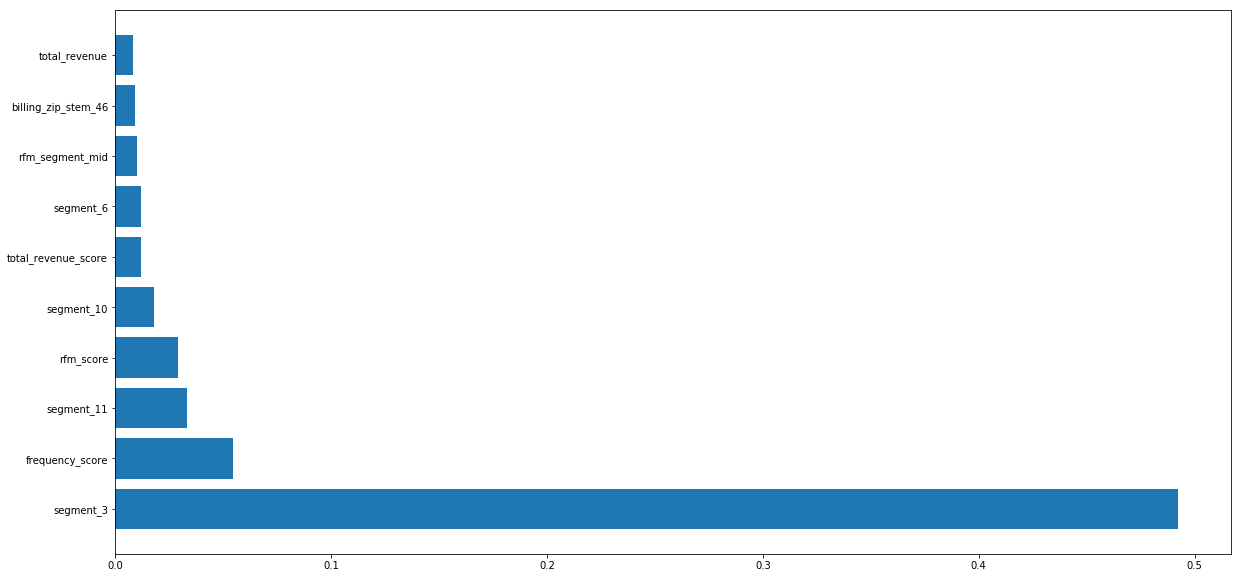

In [24]:
feature_importances = xgb_model.feature_importances_
show_feature_importance(feature_importances, model_features)

Permutation:

segment_3: 0.25
total_revenue: 0.18
segment_11: 0.18
rfm_score: 0.14
recency: 0.14
frequency_score: 0.13
total_revenue_score: 0.09
frequency: 0.05
recency_score: 0.04
segment_6: 0.02


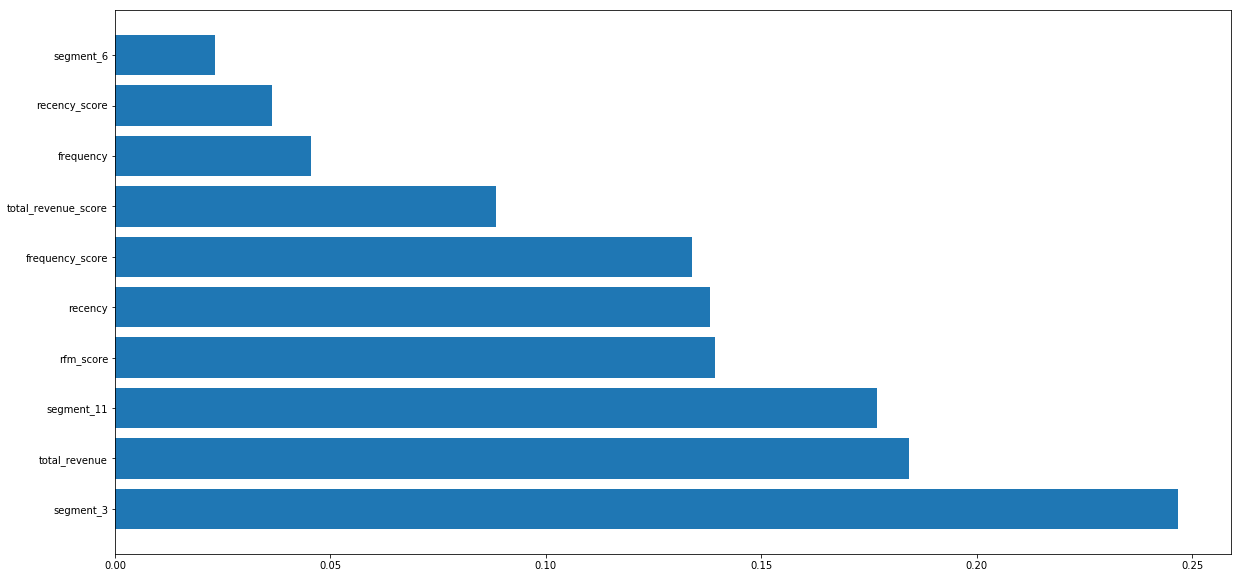

In [25]:
results = permutation_importance(xgb_model, val_features, val_target, scoring='f1')
feature_importances = results.importances_mean
show_feature_importance(feature_importances, model_features)

## Next steps